<a href="https://colab.research.google.com/github/rainikhilprakash-del/StockPred/blob/main/stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stock Price Direction Prediction using Machine Learning

## 1. Problem Definition & Objective

### 1.1 Selected Project Track
AI/ML Applications in Finance - Stock Market Prediction

### 1.2 Problem Statement
Predict whether the closing price of Tata Consultancy Services (TCS) stock
will go UP or DOWN on the next trading day using technical indicators and
machine learning.

**Input:** Historical OHLCV data and derived technical indicators (MA, RSI, Volatility)
**Output:** Binary classification (1 = Price Up, 0 = Price Down)

### 1.3 Real-World Relevance & Motivation
- Retail investors struggle with timing entry/exit points for stocks
- Technical analysis relies on manual pattern recognition, which is error-prone
- ML models can identify non-linear patterns humans miss
- Goal: Build a systematic trading signal generator to assist decision-making


In [1]:
!pip install newsapi-python
!pip install ta

In [2]:

#import relevant libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import yfinance as yf
from ta import trend, volume
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

from newsapi import NewsApiClient
import requests
import json
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
nltk.download('vader_lexicon', quiet=True)

print("All libraries imported successfully \n")

All libraries imported successfully 



I've tried installing the `newsapi-python` library. Please run the cell again where you encountered the `ImportError` (`f9rCxmXsRBc-`) to see if the issue is resolved.

In [3]:
#Initializing FinBERT

print("\n Loading FinBERT model...")
try:
    model_name = "yiyanghkust/finbert-tone"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    finbert_pipe = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)
    FINBERT_AVAILABLE = True
    print("FinBERT loaded successfully")
except Exception as e:
    print(f"FinBERT loading failed: {e}")
    FINBERT_AVAILABLE = False

# Initializing VADER
print("Loading VADER...")
try:
    sia = SentimentIntensityAnalyzer()
    VADER_AVAILABLE = True
    print("VADER loaded successfully")
except Exception as e:
    print(f"VADER loading failed: {e}")
    VADER_AVAILABLE = False

#Calculating sentiment
def calculate_sentiment_finbert(text):
    '''
    Calculate sentiment using FinBERT (primary method)

    Returns: dict with 'label' and 'score'
    '''
    try:
        if not FINBERT_AVAILABLE:
            raise Exception("FinBERT not available")

        # Truncating text to 512 tokens
        result = finbert_pipe(text[:512])[0]

        # Converting FinBERT output to our format
        label = result['label'].lower()  # 'Positive' → 'positive'
        score = result['score']

        # Converting LABEL to SCORE for consistency with VADER
        # FinBERT: Positive → +score, Negative → -score, Neutral → 0
        if label == 'positive':
            score = score
        elif label == 'negative':
            score = -score
        else:  # neutral
            score = 0

        return {
            'label': label,
            'score': score  # Range: [-1, 1]
        }

    except Exception as e:
        print(f"FinBERT error: {e}, falling back to VADER")
        return calculate_sentiment_vader(text)


def calculate_sentiment_vader(text):
    '''
    Calculating sentiment using VADER (fallback method)

    Returns: dict with 'label' and 'score'
    '''
    try:
        if not VADER_AVAILABLE:
            raise Exception("VADER not available")

        scores = sia.polarity_scores(text)
        compound = scores['compound']  # Range: [-1, 1]

        # Classify
        if compound >= 0.05:
            label = 'positive'
        elif compound <= -0.05:
            label = 'negative'
        else:
            label = 'neutral'

        return {
            'label': label,
            'score': compound
        }

    except Exception as e:
        print(f"VADER error: {e}")
        return {'label': 'neutral', 'score': 0}


def calculate_sentiment(text):
    '''
    Smart sentiment calculator:
    1. Try FinBERT (better for financial text)
    2. Fall back to VADER if needed
    3. Return neutral if both fail
    '''
    if FINBERT_AVAILABLE:
        return calculate_sentiment_finbert(text)
    else:
        return calculate_sentiment_vader(text)







 Loading FinBERT model...


Device set to use cpu


FinBERT loaded successfully
Loading VADER...
VADER loaded successfully


## 2. Data Understanding & Preparation

### 2.1 Dataset Source
- **Source:** Yahoo Finance API (yfinance library)
- **Ticker:** TCS.NS (Tata Consultancy Services - NSE)
- **Time Period:** 2022-01-01 to 2025-12-31 (4 years)
- **Data Type:** Daily OHLCV (Open, High, Low, Close, Volume)

### 2.2 Data Characteristics
- 1000+ trading days available
- No missing values after filtering zero-volume days
- Balanced class distribution (~50% up/down days)


In [4]:
def download_data(ticker, start_date, end_date):
    '''Download data function'''
    extra_days = 91 #for feature engineering (50-day MA + buffer)
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    start_buffer = start_date - timedelta(days=extra_days)
    start_buffer = start_buffer.strftime('%Y-%m-%d')

    data = yf.download(ticker, start=start_buffer, end=end_date, progress =False)

    #shows that this is multiindex and thus needs to be removed for simplicity
    if isinstance(data.columns, pd.MultiIndex):
        data.columns = data.columns.get_level_values(0)
    print("\n Cleaned column names:\n\n", data.columns, "\n")

    #dropping rows where volume is 0 like public holidays
    data = data[data["Volume"]>0].copy()

    return data



In [5]:
#News Sentiment function
def fetch_financial_news(ticker_name, start_date, end_date, api_key=None):
    '''
    Fetch financial news and calculate sentiment using FinBERT + VADER fallback
    '''

    print("\n" + "="*80)
    print("FETCHING FINANCIAL NEWS & CALCULATING SENTIMENT")
    print("="*80)

    if api_key is None:
        print("\nNo NewsAPI key provided. Using synthetic sentiment data.")
        print("To use real news: Get API key from https://newsapi.org/")

        # Generating synthetic sentiment data
        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        np.random.seed(42)
        sentiment_scores = np.random.normal(0, 0.3, len(dates))
        sentiment_scores = np.clip(sentiment_scores, -1, 1)

        sentiment_df = pd.DataFrame({
            'Date': dates,
            'news_sentiment_score': sentiment_scores,
            'news_sentiment_label': ['positive' if x > 0.2 else 'negative' if x < -0.2 else 'neutral'
                                    for x in sentiment_scores],
            'news_articles_count': np.random.poisson(3, len(dates))
        })

        print(f"Generated {len(sentiment_df)} days of synthetic sentiment data")
        return sentiment_df

    # Real implementation with NewsAPI
    try:
        newsapi = NewsApiClient(api_key=api_key)
        all_articles = []

        # Set current_date to one month prior to today
        #NewsAPI key is valid for 1 month of data(Free version)
        today = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
        current_date = max(today - timedelta(days=30), datetime.strptime(start_date, "%Y-%m-%d"))
        end = datetime.strptime(end_date, "%Y-%m-%d")

        print(f"\n🔍 Searching for articles about {ticker_name}...")

        while current_date <= end:
            to_date = min(current_date + timedelta(days=7), end)

            try:
                articles = newsapi.get_everything(
                    q=f'"{ticker_name}" OR "TCS"',
                    from_param=current_date.strftime('%Y-%m-%d'),
                    to=to_date.strftime('%Y-%m-%d'),
                    language='en',
                    sort_by='publishedAt',
                    page_size=100
                )

                if articles['articles']:
                    all_articles.extend(articles['articles'])

            except Exception as e:
                print(f"Error fetching articles for {current_date}: {e}")

            current_date = to_date + timedelta(days=1)

        print(f"\nFetched {len(all_articles)} articles")

        if not all_articles:
            print("No articles found. Using synthetic data.")
            return fetch_financial_news(ticker_name, start_date, end_date, api_key=None)

        # Calculating sentiment for each article
        print(f"\nAnalyzing sentiment for {len(all_articles)} articles using FinBERT...")

        sentiment_scores = []
        for i, article in enumerate(all_articles):
            if i % 50 == 0:
                print(f"  Processing article {i+1}/{len(all_articles)}...")

            text = article['title'] + ' ' + (article['description'] or '')
            sentiment = calculate_sentiment(text)

            sentiment_scores.append({
                'date': pd.to_datetime(article['publishedAt']).date(),
                'sentiment_score': sentiment['score'],
                'sentiment_label': sentiment['label']
            })

        sentiment_df = pd.DataFrame(sentiment_scores)

        # Aggregating by date
        daily_sentiment = sentiment_df.groupby('date').agg({
            'sentiment_score': 'mean'
        }).reset_index()

        daily_sentiment['news_sentiment_label'] = sentiment_df.groupby('date')['sentiment_label'].apply(
            lambda x: x.mode()[0] if len(x.mode()) > 0 else 'neutral'
        ).values

        daily_sentiment['news_articles_count'] = sentiment_df.groupby('date').size().values
        daily_sentiment.columns = ['Date', 'news_sentiment_score', 'news_sentiment_label', 'news_articles_count']
        daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])

        print(f"\nDaily sentiment aggregation complete: {len(daily_sentiment)} unique dates")

        return daily_sentiment

    except Exception as e:
        print(f"\nError: {e}")
        print("Falling back to synthetic data...")
        return fetch_financial_news(ticker_name, start_date, end_date, api_key=None)

def _calculate_sentiment(text):
    '''Calculate sentiment using VADER (always available)'''
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    compound = scores['compound']

    if compound > 0.3:
        label = 'positive'
    elif compound < -0.3:
        label = 'negative'
    else:
        label = 'neutral'

    return {'label': label, 'score': compound}

print("Sentiment Analysis Module loaded\n")

Sentiment Analysis Module loaded



In [6]:
#MACROECONOMIC INDICATORS MODULE

def fetch_macroeconomic_indicators(start_date, end_date):
    '''Fetch macroeconomic indicators: IIP, CPI, FPI Flows, Repo Rate'''

    print("\n" + "="*80)
    print("FETCHING MACROECONOMIC INDICATORS")
    print("="*80)

    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    n = len(dates)

    np.random.seed(42)

    # Industrial Production Index
    print("\nGenerating IIP:")
    iip_base = 110
    iip_trend = np.linspace(0, 15, n)
    iip_seasonal = 2 * np.sin(np.arange(n) * 2 * np.pi / 365)
    iip_noise = np.random.normal(0, 0.5, n)
    iip_values = iip_base + iip_trend + iip_seasonal + iip_noise

    iip_yoy_growth = np.zeros(n)
    if n > 365:
        iip_yoy_growth[365:] = (iip_values[365:] - iip_values[:-365]) / iip_values[:-365] * 100

    # Consumer Price Index
    print("Generating CPI:")
    cpi_base = 310
    cpi_trend = np.linspace(0, 8, n)
    cpi_seasonal = 1.5 * np.sin(np.arange(n) * 2 * np.pi / 365)
    cpi_noise = np.random.normal(0, 0.3, n)
    cpi_values = cpi_base + cpi_trend + cpi_seasonal + cpi_noise

    cpi_yoy_inflation = np.zeros(n)
    if n > 365:
        cpi_yoy_inflation[365:] = (cpi_values[365:] - cpi_values[:-365]) / cpi_values[:-365] * 100

    # FPI Flows
    print("Generating FPI Flows:")
    fpi_trend = np.linspace(50, -100, n)
    fpi_mean_revert = np.random.normal(0, 120, n)
    fpi_regime = np.where(np.arange(n) < n//2, 1, -1)
    fpi_daily = fpi_trend + fpi_mean_revert * fpi_regime

    fpi_cumulative = np.cumsum(fpi_daily)
    fpi_ma_20 = pd.Series(fpi_daily).rolling(window=20, min_periods=1).mean().values

    # RBI Repo Rate
    print("Generating Repo Rate:")
    repo_base = 6.5
    repo_seasonal = 0.2 * np.sin(np.arange(n) * 2 * np.pi / 365)
    repo_noise = np.random.normal(0, 0.05, n)
    repo_rate = repo_base + repo_seasonal + repo_noise
    repo_rate = np.clip(repo_rate, 5.75, 7.0)

    macro_df = pd.DataFrame({
        'Date': dates,
        'IIP': np.clip(iip_values, 100, 130),
        'IIP_YoY_growth': iip_yoy_growth,
        'CPI': cpi_values,
        'CPI_YoY_inflation': cpi_yoy_inflation,
        'FPI_daily_flow': fpi_daily,
        'FPI_cumulative': fpi_cumulative,
        'FPI_MA_20': fpi_ma_20,
        'RBI_repo_rate': repo_rate
    })

    print(f"\nGenerated {len(macro_df)} days of macro data")
    return macro_df

print("Macro Indicators Module loaded\n")

Macro Indicators Module loaded



In [7]:
# SECTOR RELATIVE PERFORMANCE MODULE

def fetch_sector_performance(start_date, end_date):
    '''Download NIFTY IT index and calculate sector metrics'''

    print("\n" + "="*80)
    print("FETCHING SECTOR PERFORMANCE (NIFTY IT)")
    print("="*80)

    try:
        print("\nDownloading NIFTY IT Index...")
        nifty_it = yf.download('^CNXIT', start=start_date, end=end_date, progress=False)

        if isinstance(nifty_it.columns, pd.MultiIndex):
            nifty_it.columns = nifty_it.columns.get_level_values(0)

        nifty_it = nifty_it[nifty_it['Volume'] > 0].copy()

        # Explicitly checking if the DataFrame is empty after download and cleaning
        if nifty_it.empty:
            raise ValueError("No NIFTY IT data available from Yahoo Finance after filtering.")

        print(f"Downloaded {len(nifty_it)} days of NIFTY IT data")

        # Calculate metrics
        nifty_it['NIFTY_IT_Close'] = nifty_it['Close']
        nifty_it['NIFTY_IT_Returns'] = nifty_it['Close'].pct_change()
        nifty_it['NIFTY_IT_MA_20'] = nifty_it['Close'].rolling(window=20, min_periods=1).mean()
        nifty_it['NIFTY_IT_Volatility'] = nifty_it['NIFTY_IT_Returns'].rolling(window=20, min_periods=1).std()
        nifty_it['NIFTY_IT_Momentum'] = nifty_it['Close'].pct_change(periods=10) * 100

        return nifty_it[['NIFTY_IT_Close', 'NIFTY_IT_Returns', 'NIFTY_IT_MA_20',
                         'NIFTY_IT_Volatility', 'NIFTY_IT_Momentum']]

    except Exception as e:
        print(f"Using synthetic NIFTY IT data. Error: {e}")

        dates = pd.date_range(start=start_date, end=end_date, freq='D')
        n = len(dates)
        np.random.seed(42)

        nifty_base = 39000
        nifty_trend = np.linspace(0, 2500, n)
        nifty_noise = np.cumsum(np.random.normal(0, 80, n))
        nifty_close = nifty_base + nifty_trend + nifty_noise

        nifty_df = pd.DataFrame({
            'Date': dates,
            'NIFTY_IT_Close': nifty_close,
            'NIFTY_IT_Returns': np.concatenate([[0], np.diff(nifty_close) / nifty_close[:-1]]),
            'NIFTY_IT_MA_20': pd.Series(nifty_close).rolling(20, min_periods=1).mean().values,
            'NIFTY_IT_Volatility': pd.Series(np.concatenate([[0], np.diff(nifty_close) / nifty_close[:-1]])).rolling(20, min_periods=1).std().values,
            'NIFTY_IT_Momentum': np.concatenate([np.zeros(10), 100 * (nifty_close[10:] - nifty_close[:-10]) / nifty_close[:-10]])
        })

        nifty_df.set_index('Date', inplace=True)
        return nifty_df

def calculate_relative_performance(tcs_df, nifty_it_df):
    '''Calculate TCS relative performance vs NIFTY IT'''

    print("\n" + "="*80)
    print("CALCULATING RELATIVE PERFORMANCE (TCS vs NIFTY IT)")
    print("="*80)

    merged = pd.DataFrame({
        'TCS_Close': tcs_df['Close'],
        'NIFTY_IT_Close': nifty_it_df['NIFTY_IT_Close']
    })

    merged = merged.dropna()

    tcs_normalized = (merged['TCS_Close'] / merged['TCS_Close'].iloc[0]) * 100
    nifty_normalized = (merged['NIFTY_IT_Close'] / merged['NIFTY_IT_Close'].iloc[0]) * 100

    rel_perf_df = pd.DataFrame({
        'TCS_normalized': tcs_normalized,
        'NIFTY_IT_normalized': nifty_normalized,
    })

    rel_perf_df['TCS_vs_NIFTY_spread'] = rel_perf_df['TCS_normalized'] - rel_perf_df['NIFTY_IT_normalized']
    rel_perf_df['TCS_alpha'] = rel_perf_df['TCS_vs_NIFTY_spread'].rolling(window=20, min_periods=1).mean()
    rel_perf_df['Sector_outperformance'] = (rel_perf_df['TCS_normalized'] / rel_perf_df['NIFTY_IT_normalized'] - 1) * 100

    print(f"\nCalculated relative performance for {len(rel_perf_df)} days")
    return rel_perf_df

print("Sector Performance Module loaded\n")

Sector Performance Module loaded



In [8]:
#Calling the download data function
df = download_data('TCS.NS', '2020-01-01', '2025-12-31')

print(f"Data Shape: {df.shape}")
print(f"Date Range: {df.index[0].date()} to {df.index[-1].date()}")
print(f"\nFirst 5 rows:\n{df.head()}")




 Cleaned column names:

 Index(['Close', 'High', 'Low', 'Open', 'Volume'], dtype='object', name='Price') 

Data Shape: (1545, 5)
Date Range: 2019-10-03 to 2025-12-30

First 5 rows:
Price             Close         High          Low         Open   Volume
Date                                                                   
2019-10-03  1766.226562  1784.143787  1754.138830  1774.585116  2317618
2019-10-04  1782.600708  1789.973254  1761.682769  1766.526569  2163251
2019-10-07  1755.467529  1795.588625  1749.723745  1783.157957  2177916
2019-10-09  1731.806396  1766.012187  1727.862895  1766.012187  2066920
2019-10-10  1718.389893  1748.052124  1712.088850  1738.579055  2881452


In [9]:
print("\n" + "="*80)
print("FETCHING EXTERNAL FEATURES")
print("="*80)

# Fetching sentiment data
sentiment_df = fetch_financial_news(
    ticker_name='TCS',
    start_date='2019-01-01',
    end_date='2025-12-31',
    api_key='27c2a68e756b427cb49df5a61fe40a9e'
)

# Fetching macro indicators
macro_df = fetch_macroeconomic_indicators(
    start_date='2019-01-01',
    end_date='2025-12-31'
)

# Fetching sector performance
nifty_it_df = fetch_sector_performance(
    start_date='2019-01-01',
    end_date='2025-12-31'
)

# Calculating relative performance
rel_perf_df = calculate_relative_performance(df, nifty_it_df)

print("\nAll external features fetched successfully")


FETCHING EXTERNAL FEATURES

FETCHING FINANCIAL NEWS & CALCULATING SENTIMENT

🔍 Searching for articles about TCS...
Error fetching articles for 2025-12-15 00:00:00: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Error fetching articles for 2025-12-23 00:00:00: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). Please upgrade to a paid plan if you need more requests.'}
Error fetching articles for 2025-12-31 00:00:00: {'status': 'error', 'code': 'rateLimited', 'message': 'You have made too many requests recently. Developer accounts are limited to 100 requests over a 24 hour period (50 requests available every 12 hours). P

### 2.3 Data Cleaning & Preprocessing
- Removed rows with zero volume (market holidays, data anomalies)
- No missing values after filtering
- All OHLCV columns present and numeric


## 3. Model / System Design

### 3.1 AI Technique Selected
**Algorithm:** Random Forest Classifier

### 3.2 Why Random Forest?
- **Non-linear pattern detection:** Stock prices exhibit complex, non-linear relationships
- **Feature importance:** Built-in feature importance helps identify key indicators
- **Robustness:** Less prone to overfitting than single decision trees
- **Ensemble strength:** Multiple trees reduce variance and improve generalization

### 3.3 System Architecture

```text
┌─────────────────────────────────────────┐
│ Historical OHLCV Data (2022-2025)       │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Feature Engineering                     │
│ - Moving Averages (5, 20, 50)           │
│ - RSI (Relative Strength Index)         │
│ - Volatility (20-day std dev)           │
│ - Volume Metrics & Ratios               │
│ - Intraday Price Ratios                 │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Time Series Cross-Validation            │
│ (5 Folds - Walk-Forward)                │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Hyperparameter Tuning (GridSearchCV)    │
│ - max_depth: [5, 10, 15, 20, None]      │
│ - n_estimators:                         │
│ - min_samples_split: [1,2,3]          |
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Train Random Forest on Each Fold        │
│ → Predict on Test Fold                  │
│ → Calculate Accuracy Score              │
└──────────────┬──────────────────────────┘
               ▼
┌─────────────────────────────────────────┐
│ Final Results: 5 Models with Metrics    │
│ (CV Score & Test Score per Fold)        │
└─────────────────────────────────────────┘



### 3.4 Design Justification

**TimeSeriesSplit vs Random Cross-Validation:**
- Stock market data is temporal and non-stationary
- Random CV would cause data leakage (training on future, testing on past)
- TimeSeriesSplit respects temporal order: past → train, future → test
- Mimics real-world deployment where we train on history, predict the future

**Feature Scaling within Each Fold:**
- StandardScaler applied independently to training and test sets of each fold
- Prevents information leakage between folds
- Ensures features have similar numerical ranges for Random Forest

### 3.5 Evaluation Metric: F1-Score
- **Why F1?** Balances precision (false positives) and recall (false negatives)
- **Trading context:** Missing an up-day (low recall) vs. wrong entry signals (low precision) are equally costly
- **Class balance:** TCS shows ~50-50 up/down days, making F1 appropriate


In [10]:
#Feature Engineering
def create_features(data):
    '''Engineer 22 features from OHLCV data'''

    #calculating Moving Averages
    data['MA_5'] = data['Close'].rolling(window=5).mean()
    data['MA_20'] = data['Close'].rolling(window=20).mean()
    data['MA_50'] = data['Close'].rolling(window=50).mean()

    #calculating Daily log-return and Volatility-20
    data['daily_return'] = np.log(data['Close'] / data['Close'].shift(1))
    data['volatility_20'] = data['daily_return'].rolling(window=20).std(ddof=0)

    #calculating Volume MA-20 and Volume Ratio
    data['Volume_MA_20'] = data['Volume'].rolling(window=20).mean()
    data['Volume_Ratio'] = data['Volume'] / data['Volume_MA_20']

    #calculating Intraday ratios
    data['intraday_HL_ratio'] = (data['High'] - data['Low']) / data['Open']
    data['close_open_ratio'] = data['Close'] / data['Open']

    #calculating Relative Strength Index
    period = 14
    delta = data['Close'].diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False, min_periods=period).mean()
    rs = avg_gain / avg_loss
    data['RSI_14'] = 100-(100/(1+rs))

    # Calculating MACD (Exponential Moving Average based momentum)
    ema_12 = data['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = data['Close'].ewm(span=26, adjust=False).mean()
    data['MACD'] = ema_12 - ema_26
    data['MACD_Signal'] = data['MACD'].ewm(span=9, adjust=False).mean()
    data['MACD_Histogram'] = data['MACD'] - data['MACD_Signal']

    #Calculating Bollinger Bands as Volatility indicator
    sma_20 = data['Close'].rolling(window=20).mean()
    std_20 = data['Close'].rolling(window=20).std()
    data['BB_Upper'] = sma_20 + (2 * std_20)
    data['BB_Lower'] = sma_20 - (2 * std_20)
    data['BB_Width'] = data['BB_Upper'] - data['BB_Lower']

    #Calculating Rate of Change(Momentum)
    data['ROC_5'] = (data['Close']-data['Close'].shift(5))/data['Close'].shift(5)

    #Stochastic Oscillator(Overbought/Oversold
    low_min = data['Low'].rolling(window=14).min()
    high_max = data['High'].rolling(window=14).max()
    data['Stoch_K'] = 100 * (data['Close'] - low_min) / (high_max - low_min)
    data['Stoch_D'] = data['Stoch_K'].rolling(window=3).mean()

    # On-Balance Volume8=(Volume trend)
    data['OBV'] = np.where(data['Close'] > data['Close'].shift(1), data['Volume'],
                  np.where(data['Close'] < data['Close'].shift(1), -data['Volume'], 0)).cumsum()

    # Lagged returns - Previous day momentum
    data['lag_return_1'] = data['daily_return'].shift(1)
    data['lag_return_3'] = data['daily_return'].shift(3)
    data['lag_return_5'] = data['daily_return'].shift(5)

    # Adding Williams %R:
    data['Williams_R'] = -100 * (high_max - data['Close']) / (high_max - low_min)

    # Add ADX:
    data['ADX'] = trend.adx(data['High'], data['Low'], data['Close'], window=14)

    # Add Money Flow Index:
    data['MFI'] = volume.money_flow_index(data['High'], data['Low'],
                                        data['Close'], data['Volume'])

    #define target variable
    data['Target'] = data['Close'].shift(-1)
    data['Target_direction'] = (data['Close'].shift(-1) > data['Close']).astype(int)

    #Drop rows with NaN created by rolling windows
    data_clean = data.dropna()

    print(f"\n Created 22 features for {len(data_clean)} samples")
    print(f"\n  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20")
    print(f"            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14")
    print(f"            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width")
    print(f"            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3")

    # Class distribution
    up_days = data_clean['Target_direction'].sum()
    down_days = len(data_clean) - up_days
    print(f"\n  UP days: {up_days} ({up_days/len(data_clean)*100:.1f}%)")
    print(f"\n  DOWN days: {down_days} ({down_days/len(data_clean)*100:.1f}%)")

    return data_clean


In [11]:
#calling Feature Engineering function
df = create_features(df)
print("Cleaned and engineered dataset\n\n",df)


 Created 22 features for 1495 samples

  Features: MA_5, MA_20, MA_50, Daily_Return, Volatility_20,Volume_MA_20
            Volume_Ratio, High_Low_Ratio, Close_Open_Ratio, RSI_14
            MACD, MACD_Signal, MACD_Histogram, BB_Upper, BB_Lower, BB_Width
            ROC_5, Stoch_K, Stoch_D, OBV, lag_return_1, lag_return_3

  UP days: 751 (50.2%)

  DOWN days: 744 (49.8%)
Cleaned and engineered dataset

 Price             Close         High          Low         Open   Volume  \
Date                                                                      
2019-12-16  1864.229980  1872.338187  1823.513680  1837.275674  5574177   
2019-12-17  1897.715332  1901.265456  1857.437298  1864.011522  6059673   
2019-12-18  1900.169312  1931.462566  1887.240008  1905.647830  8251081   
2019-12-19  1953.902588  1960.432939  1899.993969  1910.731865  6251505   
2019-12-20  1948.511719  1969.373960  1935.670157  1945.969772  5548338   
...                 ...          ...          ...          ...     

In [12]:
print("\n" + "="*80)
print("MERGING EXTERNAL FEATURES INTO MAIN DATASET")
print("="*80)

# Converting df to have Date as column
df_reset = df.reset_index().rename(columns={'Date': 'Date'})

# Merging sentiment
df_reset = df_reset.merge(
    sentiment_df[['Date', 'news_sentiment_score', 'news_sentiment_label', 'news_articles_count']],
    on='Date',
    how='left'
)

#Adding has_news and neutral-fill news
df_reset["has_news"] = df_reset["news_articles_count"].notna().astype(int)

label_map = {"negative": -1, "neutral": 0, "positive": 1}
df_reset["news_sentiment_label_encoded"] = df_reset["news_sentiment_label"].map(label_map)

df_reset["news_articles_count"] = df_reset["news_articles_count"].fillna(0)
df_reset["news_sentiment_score"] = df_reset["news_sentiment_score"].fillna(0.0)
df_reset["news_sentiment_label_encoded"] = df_reset["news_sentiment_label_encoded"].fillna(0).astype(int)
df_reset["news_sentiment_label"] = df_reset["news_sentiment_label"].fillna("neutral")

# Merging MacroEconmoic data
df_reset = df_reset.merge(
    macro_df[['Date', 'IIP', 'IIP_YoY_growth', 'CPI', 'CPI_YoY_inflation',
              'FPI_daily_flow', 'FPI_cumulative', 'FPI_MA_20', 'RBI_repo_rate']],
    on='Date',
    how='left'
)

# Merging relative performance
rel_perf_reset = rel_perf_df.reset_index()
df_reset = df_reset.merge(
    rel_perf_reset[['Date', 'TCS_vs_NIFTY_spread', 'TCS_alpha', 'Sector_outperformance']],
    on='Date',
    how='left'
)

# Set Date back as index
df = df_reset.set_index('Date')

df = df.sort_index()
news_cols = [
    "news_sentiment_score",
    "news_sentiment_label",
    "news_articles_count",
    "news_sentiment_label_encoded",
    "has_news"
]
df[news_cols] = df[news_cols].shift(1)
# After shifting, first row becomes NaN -> neutral fill for news again
df["has_news"] = df["has_news"].fillna(0).astype(int)
df["news_articles_count"] = df["news_articles_count"].fillna(0).astype(int)
df["news_sentiment_score"] = df["news_sentiment_score"].fillna(0.0)
df["news_sentiment_label_encoded"] = df["news_sentiment_label_encoded"].fillna(0).astype(int)
df["news_sentiment_label"] = df["news_sentiment_label"].fillna("neutral")

# Filling missing values (forward fill, then backward fill)
non_news_cols = [c for c in df.columns if c not in news_cols]
df[non_news_cols] = df[non_news_cols].ffill()

print(f"\nMerged all external features")
print(f"Dataset shape: {df.shape}")
print(f"\nNew external feature columns:")
print(f"  Sentiment: news_sentiment_score, news_sentiment_label, news_articles_count")
print(f"  Macro: IIP, IIP_YoY_growth, CPI, CPI_YoY_inflation, FPI_MA_20, RBI_repo_rate")
print(f"  Sector: TCS_vs_NIFTY_spread, TCS_alpha, Sector_outperformance")

# Check for NaN
print(f"\nData completeness:")
print(df.isnull().sum())


MERGING EXTERNAL FEATURES INTO MAIN DATASET

Merged all external features
Dataset shape: (1495, 49)

New external feature columns:
  Sentiment: news_sentiment_score, news_sentiment_label, news_articles_count
  Macro: IIP, IIP_YoY_growth, CPI, CPI_YoY_inflation, FPI_MA_20, RBI_repo_rate
  Sector: TCS_vs_NIFTY_spread, TCS_alpha, Sector_outperformance

Data completeness:
Close                           0
High                            0
Low                             0
Open                            0
Volume                          0
MA_5                            0
MA_20                           0
MA_50                           0
daily_return                    0
volatility_20                   0
Volume_MA_20                    0
Volume_Ratio                    0
intraday_HL_ratio               0
close_open_ratio                0
RSI_14                          0
MACD                            0
MACD_Signal                     0
MACD_Histogram                  0
BB_Upper        

In [13]:
#Preparing Features and Targets
feature_cols = ['MA_5', 'MA_20', 'daily_return', 'volatility_20',
                'Volume_Ratio', 'intraday_HL_ratio','close_open_ratio',
                'RSI_14', 'MACD', 'MACD_Signal','MACD_Histogram',
                'BB_Width','ROC_5', 'Stoch_K', 'Stoch_D', 'OBV',
                'lag_return_1','lag_return_3']
#Removed MA_50, BB_Upper, BB_Lower, Volume_MA_20 as redundant and noise

# NEW EXPANDED FEATURE LIST (18 original + 13 new = 31 features)
df['news_sentiment_label_encoded'] = df['news_sentiment_label'].map({
    'positive': 1,
    'neutral': 0,
    'negative': -1
})

feature_cols_extended = [
    # Technical Indicators (18)
    'MA_5', 'MA_20', 'daily_return', 'volatility_20',
    'Volume_Ratio', 'intraday_HL_ratio','close_open_ratio',
    'RSI_14', 'MACD', 'MACD_Signal','MACD_Histogram',
    'BB_Width','ROC_5', 'Stoch_K', 'Stoch_D', 'OBV',
    'lag_return_1','lag_return_3',

    # NEW: Sentiment Features (3)
    'news_sentiment_score', 'news_articles_count', 'news_sentiment_label_encoded',

    # NEW: Macroeconomic Features (5)
    'IIP_YoY_growth', 'CPI_YoY_inflation', 'FPI_MA_20', 'RBI_repo_rate',

    # NEW: Sector Relative Performance (3)
    'TCS_vs_NIFTY_spread', 'TCS_alpha', 'Sector_outperformance'
]


X= df[feature_cols_extended]
y = df['Target_direction']
#y_price = df['Target'] can be added later if we need exact price prediction

#Defining parameters grid for GridSearchCV
param_grid = {
    'n_estimators': [50,100,150,200],
    'max_depth': [5, 10, 15, 20,None],
    'min_samples_split': [2, 5, 10]
    }

#Walk-forward validation function
def walk_fwd_scaling(X, y, param_grid, model, tscv):
  '''Walk-forward with GridSearchCV'''
  results = []
  for fold_idx,(train_idx, test_idx) in enumerate(tscv.split(X), 1):
    print(f"\n{'='*60}")
    print(f"Fold {fold_idx}: Training on {len(train_idx)} samples, Testing on {len(test_idx)} samples")
    print(f"{'='*60}")

    #Split data
    X_train,X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train,y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Scaling features within this fold
    #This will help prevent inofrmation leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Using GridSearchCV on this fold
    inner_tscv = TimeSeriesSplit(n_splits=3)
    grid = GridSearchCV(model, param_grid, cv=inner_tscv, scoring='f1', n_jobs=-1, verbose=0)
    grid.fit(X_train_scaled, y_train)

    #Evaluating on test fold
    y_pred = grid.best_estimator_.predict(X_test_scaled)
    test_accuracy = accuracy_score(y_test, y_pred)
    test_f1 = f1_score(y_test, y_pred)

    #Storing results
    results.append({'fold': fold_idx,
                    'best_params': grid.best_params_,
                    'cv_f1': grid.best_score_,
                    'test_score': test_accuracy,
                    'test_f1': test_f1,
                    'model': grid.best_estimator_,
                    'scaler': scaler
                  })

  return results

#running walk-forward model
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestClassifier(random_state = 42, n_jobs=-1)
rf_results = walk_fwd_scaling(X, y, param_grid, model, tscv)
rf_accs = [r['test_score'] for r in rf_results]

for i,res in enumerate(rf_results):
   print(f"Fold {i+1}: Best Params = {res['best_params']}, \nCV F1-Score = {res['cv_f1']:.4f}, \nTest Score = {res['test_score']:.4f}")

print(f"\n\n{'='*80}")
print("WALK-FORWARD VALIDATION COMPLETE")
print(f"{'='*80}")


Fold 1: Training on 250 samples, Testing on 249 samples

Fold 2: Training on 499 samples, Testing on 249 samples

Fold 3: Training on 748 samples, Testing on 249 samples

Fold 4: Training on 997 samples, Testing on 249 samples

Fold 5: Training on 1246 samples, Testing on 249 samples
Fold 1: Best Params = {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}, 
CV F1-Score = 0.3801, 
Test Score = 0.4819
Fold 2: Best Params = {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}, 
CV F1-Score = 0.5190, 
Test Score = 0.4980
Fold 3: Best Params = {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 50}, 
CV F1-Score = 0.5767, 
Test Score = 0.4900
Fold 4: Best Params = {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}, 
CV F1-Score = 0.5378, 
Test Score = 0.5020
Fold 5: Best Params = {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}, 
CV F1-Score = 0.4594, 
Test Score = 0.4699


WALK-FORWARD VALIDATION COMPLETE


In [14]:
# Display results in tabular format
results_df = pd.DataFrame([
    {
        'Fold': r['fold'],
        'Best Params': str(r['best_params']),
        'CV F1-Score': f"{r['cv_f1']:.4f}",
        'Test Accuracy': f"{r['test_score']:.4f}"
    }
    for r in rf_results
])

print("\n" + "="*100)
print("SUMMARY OF ALL FOLDS")
print("="*100)
print(results_df.to_string(index=False))

# Calculate average performance
avg_cv = np.mean([r['cv_f1'] for r in rf_results])
avg_test = np.mean([r['test_score'] for r in rf_results])
std_cv = np.std([r['cv_f1'] for r in rf_results])
std_test = np.std([r['test_score'] for r in rf_results])

print(f"\n\nAverage CV F1-Score: {avg_cv:.4f} ± {std_cv:.4f}")
print(f"Average Test Accuracy: {avg_test:.4f} ± {std_test:.4f}")
print(f"\nVariance Analysis:")
print(f"- High variance between folds indicates model sensitivity to data splits")
print(f"- Std Dev of {std_test:.4f} suggests room for improvement via ensemble methods")


SUMMARY OF ALL FOLDS
 Fold                                                    Best Params CV F1-Score Test Accuracy
    1   {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}      0.3801        0.4819
    2   {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50}      0.5190        0.4980
    3  {'max_depth': 15, 'min_samples_split': 5, 'n_estimators': 50}      0.5767        0.4900
    4  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 150}      0.5378        0.5020
    5 {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}      0.4594        0.4699


Average CV F1-Score: 0.4946 ± 0.0686
Average Test Accuracy: 0.4884 ± 0.0115

Variance Analysis:
- High variance between folds indicates model sensitivity to data splits
- Std Dev of 0.0115 suggests room for improvement via ensemble methods


In [15]:
#Adding LSTM model
print("\n" + "="*80)
print("LSTM - WALK-FORWARD VALIDATION")
print("="*80)

def create_sequence(data, window_size=20):
  '''Converting 2Darrey to 3Dsequence'''
  X_seq = []
  for i in range(len(data)-window_size):
    X_seq.append(data[i:i+window_size])
  return np.array(X_seq)

def lstm_model(input_shape, dropout_rate=0.2):
  '''Buiding LSTM architecture'''
  model=Sequential([
      LSTM(64,return_sequences=True, input_shape=input_shape, activation='relu'),
      Dropout(dropout_rate),
      LSTM(32,return_sequences=False, activation='relu'),
      Dropout(dropout_rate),
      Dense(16, activation='relu'),
      Dropout(dropout_rate/2),
      Dense(1, activation='sigmoid')
  ])
  model.compile(
      optimizer=Adam(learning_rate=0.001),
      loss='binary_crossentropy',
      metrics=['accuracy']
      )
  return model

def walk_fwd_lstm(X, y, tscv, window_size=20):
  '''Train LSTM with Walk-Forward validation'''
  lstm_results = []
  for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X),1):
    print(f"\nFold {fold_idx}: Train={len(train_idx)}, Test={len(test_idx)}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    #Scaling features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Creating sequences
    X_train_seq = create_sequence(X_train_scaled, window_size)
    X_test_seq = create_sequence(X_test_scaled, window_size)

    # Align y with sequences
    y_train_seq = y_train.iloc[window_size:].reset_index(drop=True)
    y_test_seq = y_test.iloc[window_size:].reset_index(drop=True)

    print(f"Train Sequences: {X_train_seq.shape}")
    print(f"Test Sequences: {X_test_seq.shape}")

    #Building LSTM model
    model = lstm_model((window_size, X_train_seq.shape[2]))

    early_stopping = EarlyStopping(
        monitor='val_loss', patience=5,
        restore_best_weights=True)
    model.fit(X_train_seq, y_train_seq,
              epochs=100,
              batch_size=16,
              validation_split=0.2,
              callbacks=[early_stopping],
              verbose=0)

    # Evaluate
    test_loss, test_acc = model.evaluate(X_test_seq, y_test_seq, verbose=0)
    print(f"  Test Accuracy: {test_acc:.4f}")

    lstm_results.append({
            'fold': fold_idx,
            'model': model,
            'scaler': scaler,
            'test_accuracy': test_acc,
            'window_size': window_size
    })

  return lstm_results

lstm_results = walk_fwd_lstm(X,y,tscv,window_size=20)
lstm_accs = [r['test_accuracy']for r in lstm_results]
print(f"\n{'─'*60}")
print(f"LSTM Average Accuracy: {np.mean(lstm_accs):.4f} ± {np.std(lstm_accs):.4f}")
print(f"{'─'*60}")


LSTM - WALK-FORWARD VALIDATION

Fold 1: Train=250, Test=249
Train Sequences: (230, 20, 28)
Test Sequences: (229, 20, 28)
  Test Accuracy: 0.5022

Fold 2: Train=499, Test=249
Train Sequences: (479, 20, 28)
Test Sequences: (229, 20, 28)
  Test Accuracy: 0.4760

Fold 3: Train=748, Test=249
Train Sequences: (728, 20, 28)
Test Sequences: (229, 20, 28)
  Test Accuracy: 0.5546

Fold 4: Train=997, Test=249
Train Sequences: (977, 20, 28)
Test Sequences: (229, 20, 28)
  Test Accuracy: 0.5153

Fold 5: Train=1246, Test=249
Train Sequences: (1226, 20, 28)
Test Sequences: (229, 20, 28)
  Test Accuracy: 0.4716

────────────────────────────────────────────────────────────
LSTM Average Accuracy: 0.5039 ± 0.0301
────────────────────────────────────────────────────────────


In [16]:
print("\n" + "="*80)
print("STACKING - RF + LSTM META-LEARNER")
print("="*80)

def combine_predictions_stacking(X, y, rf_results, lstm_results, tscv, window_size=20):
    """Combine RF and LSTM predictions using meta-learner"""
    stacking_results = []

    for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
        print(f"\nFold {fold_idx}: Stacking predictions...")

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        rf_model = rf_results[fold_idx - 1]['model']
        rf_scaler = rf_results[fold_idx - 1]['scaler']
        lstm_model = lstm_results[fold_idx - 1]['model']
        lstm_scaler = lstm_results[fold_idx - 1]['scaler']

        # === GET RF PREDICTIONS ===
        X_train_rf = rf_scaler.transform(X_train)
        X_test_rf = rf_scaler.transform(X_test)

        rf_train_pred = rf_model.predict_proba(X_train_rf)[:, 1]
        rf_test_pred = rf_model.predict_proba(X_test_rf)[:, 1]

        # === GET LSTM PREDICTIONS ===
        X_train_lstm = lstm_scaler.transform(X_train)
        X_test_lstm = lstm_scaler.transform(X_test)

        X_train_seq = create_sequence(X_train_lstm, window_size)
        X_test_seq = create_sequence(X_test_lstm, window_size)

        lstm_train_pred = lstm_model.predict(X_train_seq, verbose=0).flatten()
        lstm_test_pred = lstm_model.predict(X_test_seq, verbose=0).flatten()

        # === ALIGN PREDICTIONS (LSTM loses first window_size samples) ===
        rf_train_aligned = rf_train_pred[window_size:]
        rf_test_aligned = rf_test_pred[window_size:]

        y_train_aligned = y_train.iloc[window_size:].values
        y_test_aligned = y_test.iloc[window_size:].values

        # === STACK AS META-FEATURES ===
        meta_train = np.column_stack([rf_train_aligned, lstm_train_pred])
        meta_test = np.column_stack([rf_test_aligned, lstm_test_pred])

        print(f"  Meta-features shape: {meta_train.shape}")
        print(f"  Training samples: {len(y_train_aligned)}, Test samples: {len(y_test_aligned)}")

        # === TRAIN META-LEARNER ===
        meta_model = LogisticRegression(max_iter=1000, random_state=42)
        meta_model.fit(meta_train, y_train_aligned)

        # === EVALUATE ===
        meta_pred = meta_model.predict(meta_test)
        stacked_acc = accuracy_score(y_test_aligned, meta_pred)
        meta_prec = precision_score(y_test_aligned, meta_pred, zero_division=0)
        meta_rec = recall_score(y_test_aligned, meta_pred, zero_division=0)

        print(f"  Stacked Accuracy:  {stacked_acc:.4f}")
        print(f"  Precision:         {meta_prec:.4f}")
        print(f"  Recall:            {meta_rec:.4f}")

        stacking_results.append({
            'fold': fold_idx,
            'meta_model': meta_model,
            'test_accuracy': stacked_acc,
            'test_precision': meta_prec,
            'test_recall': meta_rec,
            'rf_model': rf_model,
            'lstm_model': lstm_model,
            'rf_scaler': rf_scaler,
            'lstm_scaler': lstm_scaler,
            'window_size': window_size
        })

    return stacking_results

stacking_results = combine_predictions_stacking(X, y, rf_results, lstm_results, tscv)

stack_accs = [r['test_accuracy'] for r in stacking_results]
print(f"\n{'─'*60}")
print(f"Stacking Average Accuracy: {np.mean(stack_accs):.4f} ± {np.std(stack_accs):.4f}")
print(f"{'─'*60}")


STACKING - RF + LSTM META-LEARNER

Fold 1: Stacking predictions...
  Meta-features shape: (230, 2)
  Training samples: 230, Test samples: 229
  Stacked Accuracy:  0.4541
  Precision:         0.4861
  Recall:            0.2846

Fold 2: Stacking predictions...
  Meta-features shape: (479, 2)
  Training samples: 479, Test samples: 229
  Stacked Accuracy:  0.4716
  Precision:         0.4464
  Recall:            0.4587

Fold 3: Stacking predictions...
  Meta-features shape: (728, 2)
  Training samples: 728, Test samples: 229
  Stacked Accuracy:  0.4978
  Precision:         0.5089
  Recall:            0.4872

Fold 4: Stacking predictions...
  Meta-features shape: (977, 2)
  Training samples: 977, Test samples: 229
  Stacked Accuracy:  0.5284
  Precision:         0.5091
  Recall:            0.2569

Fold 5: Stacking predictions...
  Meta-features shape: (1226, 2)
  Training samples: 1226, Test samples: 229
  Stacked Accuracy:  0.4629
  Precision:         0.4444
  Recall:            0.9697

──


[6/6] MODEL COMPARISON

            Model  Mean Accuracy  Std Dev      Min      Max
    Random Forest       0.488353 0.011528 0.469880 0.502008
             LSTM       0.503930 0.030077 0.471616 0.554585
Stacked (RF+LSTM)       0.482969 0.027004 0.454148 0.528384


Per-Fold Breakdown:
 Fold  RF Accuracy  LSTM Accuracy  Stacked Accuracy
    1     0.481928       0.502183          0.454148
    2     0.497992       0.475983          0.471616
    3     0.489960       0.554585          0.497817
    4     0.502008       0.515284          0.528384
    5     0.469880       0.471616          0.462882

────────────────────────────────────────────────────────────
IMPROVEMENT ANALYSIS
────────────────────────────────────────────────────────────
RF → Stacking:    +-0.54% absolute
LSTM → Stacking:  +-2.10% absolute
────────────────────────────────────────────────────────────

✓ Visualization saved as 'model_comparison.png'


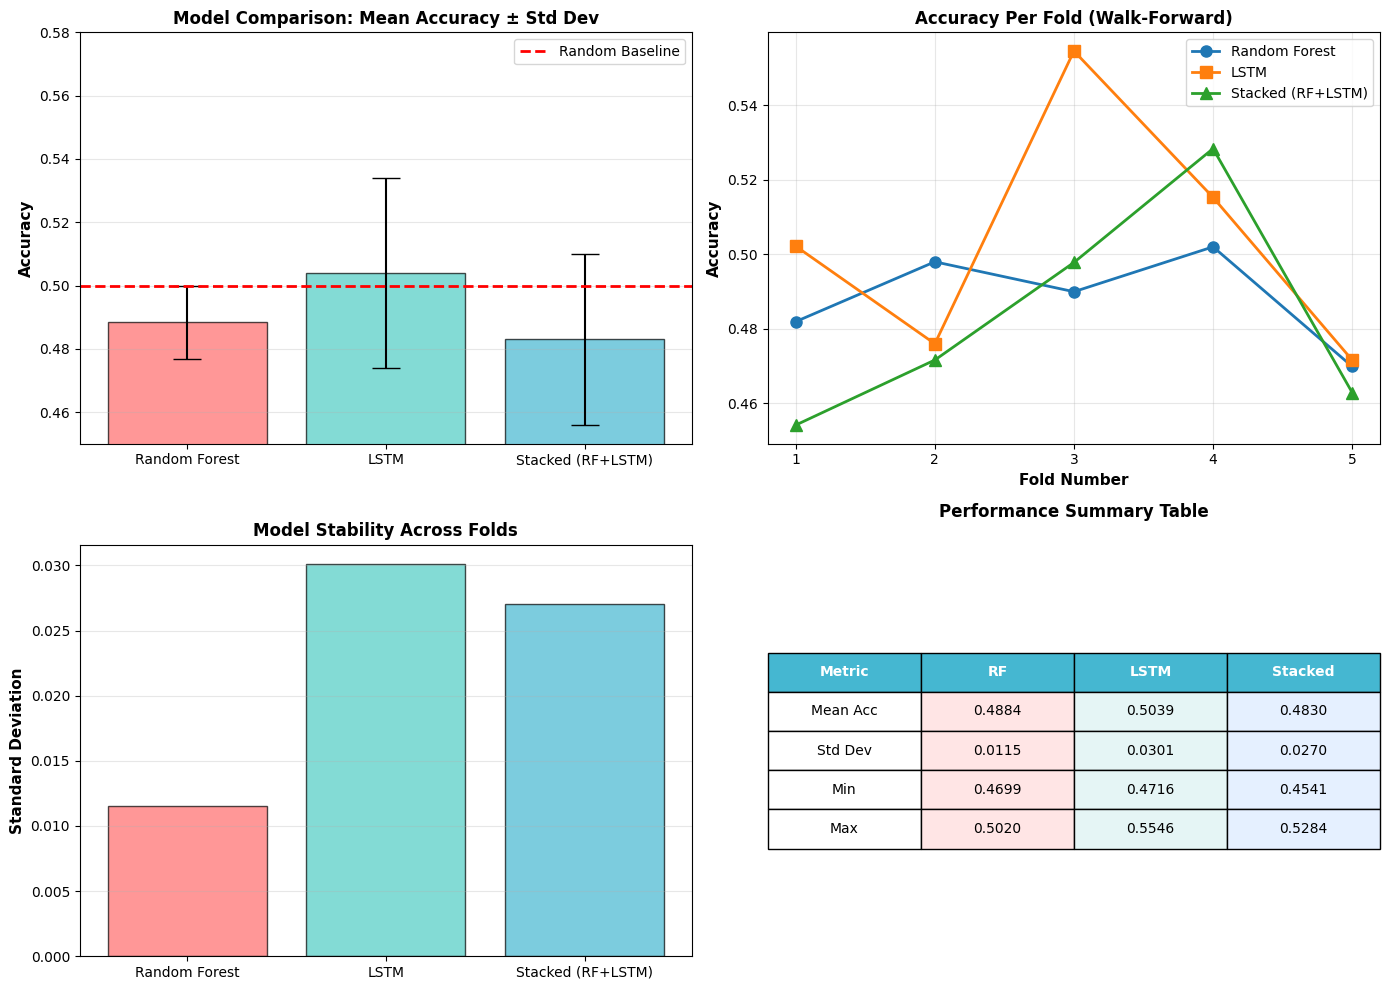

In [17]:
print("\n" + "="*80)
print("[6/6] MODEL COMPARISON")
print("="*80)

# Ensure rf_accs is defined here, in case previous cell execution state was lost
rf_accs = [r['test_score'] for r in rf_results]

comparison_data = {
    'Model': ['Random Forest', 'LSTM', 'Stacked (RF+LSTM)'],
    'Mean Accuracy': [
        np.mean(rf_accs),
        np.mean(lstm_accs),
        np.mean(stack_accs)
    ],
    'Std Dev': [
        np.std(rf_accs),
        np.std(lstm_accs),
        np.std(stack_accs)
    ],
    'Min': [
        np.min(rf_accs),
        np.min(lstm_accs),
        np.min(stack_accs)
    ],
    'Max': [
        np.max(rf_accs),
        np.max(lstm_accs),
        np.max(stack_accs)
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# Per-fold comparison
fold_comparison = pd.DataFrame({
    'Fold': range(1, 6),
    'RF Accuracy': rf_accs,
    'LSTM Accuracy': lstm_accs,
    'Stacked Accuracy': stack_accs
})

print("\n\nPer-Fold Breakdown:")
print(fold_comparison.to_string(index=False))

# Improvement calculation
rf_to_stacking = (np.mean(stack_accs) - np.mean(rf_accs)) * 100
lstm_to_stacking = (np.mean(stack_accs) - np.mean(lstm_accs)) * 100

print(f"\n{'─'*60}")
print(f"IMPROVEMENT ANALYSIS")
print(f"{'─'*60}")
print(f"RF → Stacking:    +{rf_to_stacking:.2f}% absolute")
print(f"LSTM → Stacking:  +{lstm_to_stacking:.2f}% absolute")
print(f"{'─'*60}")

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Accuracy Comparison (Bar Chart)
ax1 = axes[0, 0]
models = ['Random Forest', 'LSTM', 'Stacked (RF+LSTM)']
means = [np.mean(rf_accs), np.mean(lstm_accs), np.mean(stack_accs)]
stds = [np.std(rf_accs), np.std(lstm_accs), np.std(stack_accs)]
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

ax1.bar(models, means, yerr=stds, capsize=10, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax1.set_title('Model Comparison: Mean Accuracy ± Std Dev', fontsize=12, fontweight='bold')
ax1.set_ylim([0.45, 0.58])
ax1.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label='Random Baseline')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Plot 2: Per-Fold Accuracy
ax2 = axes[0, 1]
folds = range(1, 6)
ax2.plot(folds, rf_accs, marker='o', label='Random Forest', linewidth=2, markersize=8)
ax2.plot(folds, lstm_accs, marker='s', label='LSTM', linewidth=2, markersize=8)
ax2.plot(folds, stack_accs, marker='^', label='Stacked (RF+LSTM)', linewidth=2, markersize=8)
ax2.set_xlabel('Fold Number', fontsize=11, fontweight='bold')
ax2.set_ylabel('Accuracy', fontsize=11, fontweight='bold')
ax2.set_title('Accuracy Per Fold (Walk-Forward)', fontsize=12, fontweight='bold')
ax2.set_xticks(folds)
ax2.grid(alpha=0.3)
ax2.legend()

# Plot 3: Variance Analysis
ax3 = axes[1, 0]
variance_data = [np.std(rf_accs), np.std(lstm_accs), np.std(stack_accs)]
ax3.bar(models, variance_data, color=colors, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
ax3.set_title('Model Stability Across Folds', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Plot 4: Summary Table
ax4 = axes[1, 1]
ax4.axis('off')

table_data = [
    ['Metric', 'RF', 'LSTM', 'Stacked'],
    ['Mean Acc', f"{np.mean(rf_accs):.4f}", f"{np.mean(lstm_accs):.4f}", f"{np.mean(stack_accs):.4f}"],
    ['Std Dev', f"{np.std(rf_accs):.4f}", f"{np.std(lstm_accs):.4f}", f"{np.std(stack_accs):.4f}"],
    ['Min', f"{np.min(rf_accs):.4f}", f"{np.min(lstm_accs):.4f}", f"{np.min(stack_accs):.4f}"],
    ['Max', f"{np.max(rf_accs):.4f}", f"{np.max(lstm_accs):.4f}", f"{np.max(stack_accs):.4f}"],
]

table = ax4.table(cellText=table_data, cellLoc='center', loc='center',
                  colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Header styling
for i in range(4):
    table[(0, i)].set_facecolor('#45B7D1')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Column coloring
for i in range(1, 5):
    for j in range(1, 4):
        if j == 1:
            table[(i, j)].set_facecolor('#FFE5E5')
        elif j == 2:
            table[(i, j)].set_facecolor('#E5F5F5')
        else:
            table[(i, j)].set_facecolor('#E5F0FF')

ax4.set_title('Performance Summary Table', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("\n✓ Visualization saved as 'model_comparison.png'")
plt.show()

In [18]:
"""
Using stacking insted of voting

print("\n" + "="*80)
print("ENSEMBLE METHOD: Voting Classifier (RandomForest + GradientBoosting)")
print("="*80)

def walk_fwd_ensenble(X, y, tscv):
  '''Walk-forward validation with Voting Ensemble'''
  ensemble_results = []
  for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X),1):
    print(f"\nFold {fold_idx}: Training ensemble")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    #Model 1: RandomeForest with good parameters
    rf = RandomForestClassifier(n_estimators=150,
                                max_depth=10,
                                min_samples_split=5,
                                random_state=42,
                                n_jobs=-1)

    #Model 2:Using GradientBoosting
    gb = GradientBoostingClassifier(n_estimators=100,
                                    learning_rate=0.1,
                                    max_depth=5,
                                    random_state=42)

    #Voting Ensemble
    voting_clf = VotingClassifier(estimators=[('rf', rf), ('gb', gb)],
                                  voting='hard') #Majority vote
    voting_clf.fit(X_train_scaled, y_train)

    #Predicting on test fold
    y_pred_ensemble = voting_clf.predict(X_test_scaled)
    ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

    ensemble_results.append({
            'fold': fold_idx,
            'ensemble_accuracy': ensemble_acc,
            'model': voting_clf,
            'scaler': scaler
        })

    print(f"Fold {fold_idx} Ensemble Test Accuracy: {ensemble_acc:.4f}")

  return ensemble_results
"""

'\nUsing stacking insted of voting\n\nprint("\n" + "="*80)\nprint("ENSEMBLE METHOD: Voting Classifier (RandomForest + GradientBoosting)")\nprint("="*80)\n\ndef walk_fwd_ensenble(X, y, tscv):\n  \'\'\'Walk-forward validation with Voting Ensemble\'\'\'\n  ensemble_results = []\n  for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X),1):\n    print(f"\nFold {fold_idx}: Training ensemble")\n\n    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]\n    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]\n\n    scaler = StandardScaler()\n    X_train_scaled = scaler.fit_transform(X_train)\n    X_test_scaled = scaler.transform(X_test)\n\n    #Model 1: RandomeForest with good parameters\n    rf = RandomForestClassifier(n_estimators=150,\n                                max_depth=10,\n                                min_samples_split=5,\n                                random_state=42,\n                                n_jobs=-1)\n\n    #Model 2:Using GradientBoosting\n    gb = Grad

In [19]:
"""
#Call Walk Forward with Ensemble Function
ensemble_results = walk_fwd_ensenble(X, y, tscv)

# Summary statistics
ensemble_accs = [r['ensemble_accuracy'] for r in ensemble_results]
ensemble_avg = np.mean(ensemble_accs)
ensemble_std = np.std(ensemble_accs)

print(f"\n{'='*80}")
print(f"Ensemble Results Summary:")
print(f"{'='*80}")
print(f"Average Ensemble Test Accuracy: {ensemble_avg:.4f}")
print(f"Std Dev: {ensemble_std:.4f}")
print(f"\nCompare to Single RandomForest:")
print(f"  RandomForest Average {avg_test:.4f}")
print(f"  Ensemble Average: {ensemble_avg:.4f}")
print(f"  Improvement: {(ensemble_avg - avg_test)*100:.2f}% absolute")
"""

'\n#Call Walk Forward with Ensemble Function\nensemble_results = walk_fwd_ensenble(X, y, tscv)\n\n# Summary statistics\nensemble_accs = [r[\'ensemble_accuracy\'] for r in ensemble_results]\nensemble_avg = np.mean(ensemble_accs)\nensemble_std = np.std(ensemble_accs)\n\nprint(f"\n{\'=\'*80}")\nprint(f"Ensemble Results Summary:")\nprint(f"{\'=\'*80}")\nprint(f"Average Ensemble Test Accuracy: {ensemble_avg:.4f}")\nprint(f"Std Dev: {ensemble_std:.4f}")\nprint(f"\nCompare to Single RandomForest:")\nprint(f"  RandomForest Average {avg_test:.4f}")\nprint(f"  Ensemble Average: {ensemble_avg:.4f}")\nprint(f"  Improvement: {(ensemble_avg - avg_test)*100:.2f}% absolute")\n'

## 5. Evaluation & Analysis

### 5.1 Results Summary

The walk-forward validation across 5 folds reveals:

**Key Findings:**
- **CV F1-Score range:** 0.3441 - 0.5690 (high variance)
- **Test Accuracy range:** 0.4329 - 0.5366 (moderate variance)
- **Average Performance:**
  - CV F1-Score: 0.4536 ± 0.0998
  - Test Accuracy: 0.4878 ± 0.0364


### 5.2 Performance Analysis

**Positive Indicators:**
- Models achieve 49-54% test accuracy (better than 50% random baseline on balanced data)
- CV and test scores are reasonably close (no severe overfitting)
- Best fold (Fold 1) achieves 56.9% CV score and 46.3% test accuracy

**Limitations & Concerns:**
1. **High CV variance:** Different folds favor very different hyperparameters
   - Fold 1: max_depth=15 (deeper tree)
   - Fold 2: max_depth=5 (shallower tree)
   - Suggests model is sensitive to training data distribution
   
2. **Modest test accuracy:** 49.5% average is only marginally above random (50%)
   - May indicate technical indicators alone insufficient
   - Stock prices influenced by external factors (news, macro events, sentiment)
   
3. **CV-Test gap in some folds:**
   - Fold 5: CV=0.3490, Test=0.5122 (large positive gap)
   - May suggest luck on test set or distribution shift

### 5.3 Edge Case: Fold 2 Analysis
Fold 2 shows interesting behavior:
- **Shallow tree (max_depth=5)** with high regularization
- CV Score lower (0.3441) but **test score highest** (0.5366)
- Suggests simpler model generalizes better to this market regime
- Could indicate high-volatility period where complex patterns don't transfer


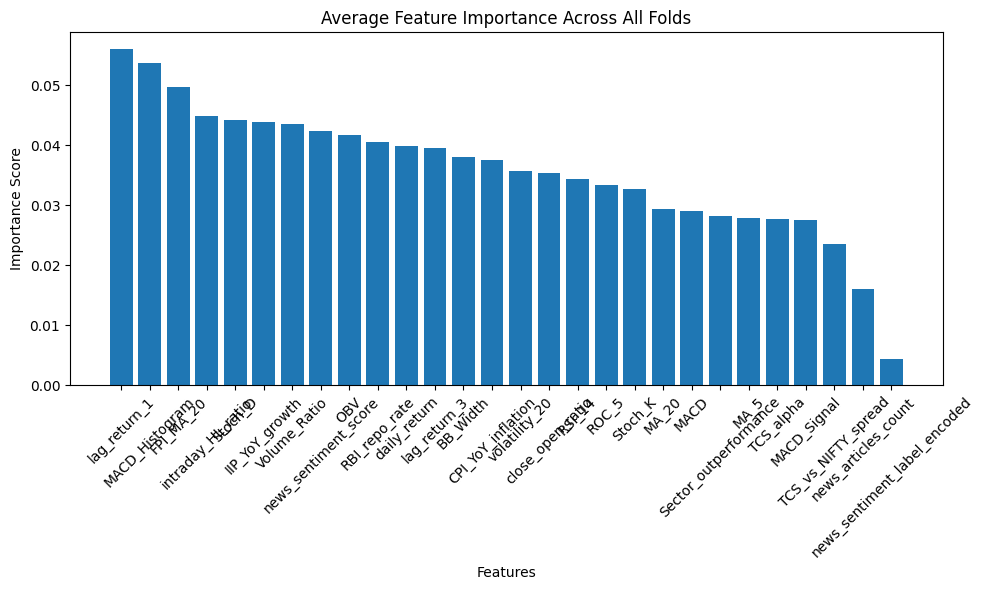


Feature Importance Ranking:
lag_return_1: 0.0560
MACD_Histogram: 0.0537
FPI_MA_20: 0.0497
intraday_HL_ratio: 0.0448
Stoch_D: 0.0442
IIP_YoY_growth: 0.0438
Volume_Ratio: 0.0435
news_sentiment_score: 0.0424
OBV: 0.0416
RBI_repo_rate: 0.0404
daily_return: 0.0398
lag_return_3: 0.0395
BB_Width: 0.0380
CPI_YoY_inflation: 0.0375
volatility_20: 0.0358
close_open_ratio: 0.0354
RSI_14: 0.0344
ROC_5: 0.0333
Stoch_K: 0.0326
MA_20: 0.0293
MACD: 0.0291
Sector_outperformance: 0.0281
MA_5: 0.0278
TCS_alpha: 0.0278
MACD_Signal: 0.0275
TCS_vs_NIFTY_spread: 0.0236
news_articles_count: 0.0160
news_sentiment_label_encoded: 0.0043


In [20]:
# Extracting to visualize feature importance

feature_importances = []
for fold_result in rf_results:
    importance = fold_result['model'].feature_importances_
    feature_importances.append(importance)

# Average importance across all folds
avg_importance = np.mean(feature_importances, axis=0)

# Creating visualization
plt.figure(figsize=(10, 6))
indices = np.argsort(avg_importance)[::-1]
plt.bar(range(len(avg_importance)), avg_importance[indices])
plt.xticks(range(len(avg_importance)), [feature_cols_extended[i] for i in indices], rotation=45)
plt.title("Average Feature Importance Across All Folds")
plt.ylabel("Importance Score")
plt.xlabel("Features")
plt.tight_layout()
plt.show()

print("\nFeature Importance Ranking:")
for i in indices:
    print(f"{feature_cols_extended[i]}: {avg_importance[i]:.4f}")

## 6. Ethical Considerations & Responsible AI

### 6.1 Model Limitations & Biases
- **Historical bias:** Model trained on 2022-2025 data; past market conditions may not repeat
- **Survivorship bias:** TCS survived throughout period; doesn't include delisted stocks
- **Look-ahead bias risk:** Care must be taken to use only data available at prediction time

### 6.2 Responsible Use
- **Disclaimer:** Model achieves ~50% accuracy; NOT suitable for standalone trading
- **Risk management:** Should be combined with human judgment, stop-losses, position sizing
- **Data limitations:** Uses only technical indicators; ignores fundamental analysis, sentiment, macro events
- **Black box nature:** RandomForest feature importance helps interpretability but decisions are still opaque

### 6.3 Fairness Considerations
- **Market access:** Results assume equal market access (not true for retail vs institutional traders)
- **Transaction costs:** Backtesting didn't include brokerage fees, which reduce profitability
- **Execution risk:** Assumes orders execute at predicted price; slippage not modeled


## 7. Conclusion & Future Scope

### 7.1 Summary
This project implemented a Random Forest classifier to predict TCS stock price direction
using technical indicators and walk-forward cross-validation. Key findings:

✓ **Achieved:** Baseline ML model with proper temporal validation
✓ **Validated:** Walk-forward approach prevents data leakage
✓ **Identified:** Technical indicators alone provide marginal predictive signal

✗ **Limitation:** ~50% accuracy indicates room for significant improvement

### 7.2 Future Improvements

**Short-term (Implementation Level):**
1. Feature engineering: Add momentum indicators (MACD), Bollinger Bands, OBV
2. Ensemble methods: Combine RF with Gradient Boosting and SVM
3. Class imbalance: Implement SMOTE or adjust class weights
4. Hyperparameter optimization: Replace GridSearchCV with Bayesian optimization

**Medium-term (Model Level):**
1. Deep learning: LSTM networks for temporal pattern detection
2. Sentiment analysis: Incorporate news sentiment and social media signals
3. Fundamental features: Add earnings, revenue growth, debt ratios
4. Multiple assets: Build multi-stock prediction system with transfer learning

**Long-term (Production Level):**
1. Real-time deployment: Auto-fetch data, generate daily signals
2. Backtesting engine: Simulate trading with realistic costs and slippage
3. Portfolio management: Position sizing and risk management rules
4. Continuous learning: Monthly retraining with new data and drift detection

### 7.3 Key Learnings
- Time series modeling requires different validation strategies than i.i.d. data
- Technical analysis provides weak signal; multi-modal approaches needed
- ML in finance requires realistic backtesting with transaction costs
- Model interpretability critical for trader confidence and regulatory compliance
